# Labsheet 3
## Name: Aniketh Vijesh
## Roll No: AM.EN.U4AIE22009

### Otsu Thresholding

TODO:
- store sigma vals
- compute pixel frequecies for background and foreground
- compter mean pixel intensity for background and foreground
- compute between class variance
- find threshold value that maximizes between class variance

In [36]:
import numpy as np
import PIL
import matplotlib.pyplot as plt 

def otsu_thresholding(image_path):
    thresh_vals = dict()
    sigma = []
    
    # Load image in grayscale
    image = np.array(PIL.Image.open(image_path).convert('L'))  
    
    intensities = np.unique(image)
    vals = np.random.randint(min(intensities), max(intensities), size=(10,))
    
    total_pixels = image.size  
    
    for val in vals:
        num_b = np.sum(image <= val)
        num_f = np.sum(image > val)

        if num_b == 0 or num_f == 0:
            sigma.append(0)
            thresh_vals[val] = 0
            continue
        
        # Compute sum of intensities in background & foreground
        nub = np.sum(image[image <= val])
        nuf = np.sum(image[image > val])
        
        # Compute means
        mean_b = nub / num_b if num_b > 0 else 0
        mean_f = nuf / num_f if num_f > 0 else 0
        
        wb = num_b / total_pixels
        wf = num_f / total_pixels
        
        # Compute Otsu's variance
        variance = wb * wf * (mean_b - mean_f) ** 2
        sigma.append(variance)
        thresh_vals[val] = variance
    
    # Find the threshold with the highest variance
    best_threshold = max(thresh_vals, key=thresh_vals.get)
    
    print("Threshold values:", vals)
    print("Between class variance (σ²):", sigma)
    print("Best threshold value:", best_threshold, "with σ²:", thresh_vals[best_threshold])

    # Apply threshold using NumPy indexing
    thresholded_image = np.where(image > best_threshold, 255, 0).astype(np.uint8)

    # Display thresholded image
    plt.imshow(thresholded_image, cmap='gray')
    plt.title(f"Otsu Thresholding (Threshold={best_threshold})")
    plt.axis("off")
    plt.show()

    return best_threshold


Threshold values: [ 29 113  40  53 186 115 180  15 220  99]
Between class variance (σ²): [85.5482296570391, 2430.2071108238024, 359.81107304524767, 704.423260237824, 1732.426216192609, 2439.665687393461, 1941.2814084321606, 11.824287176763875, 537.8288314082396, 2291.6519150854733]
Best threshold value: 115 with σ²: 2439.665687393461


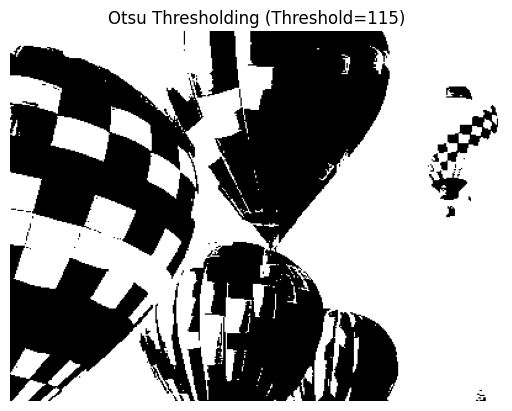

115

In [37]:
otsu_thresholding('./Lab 1.jpg')

### Watershed Segmentation

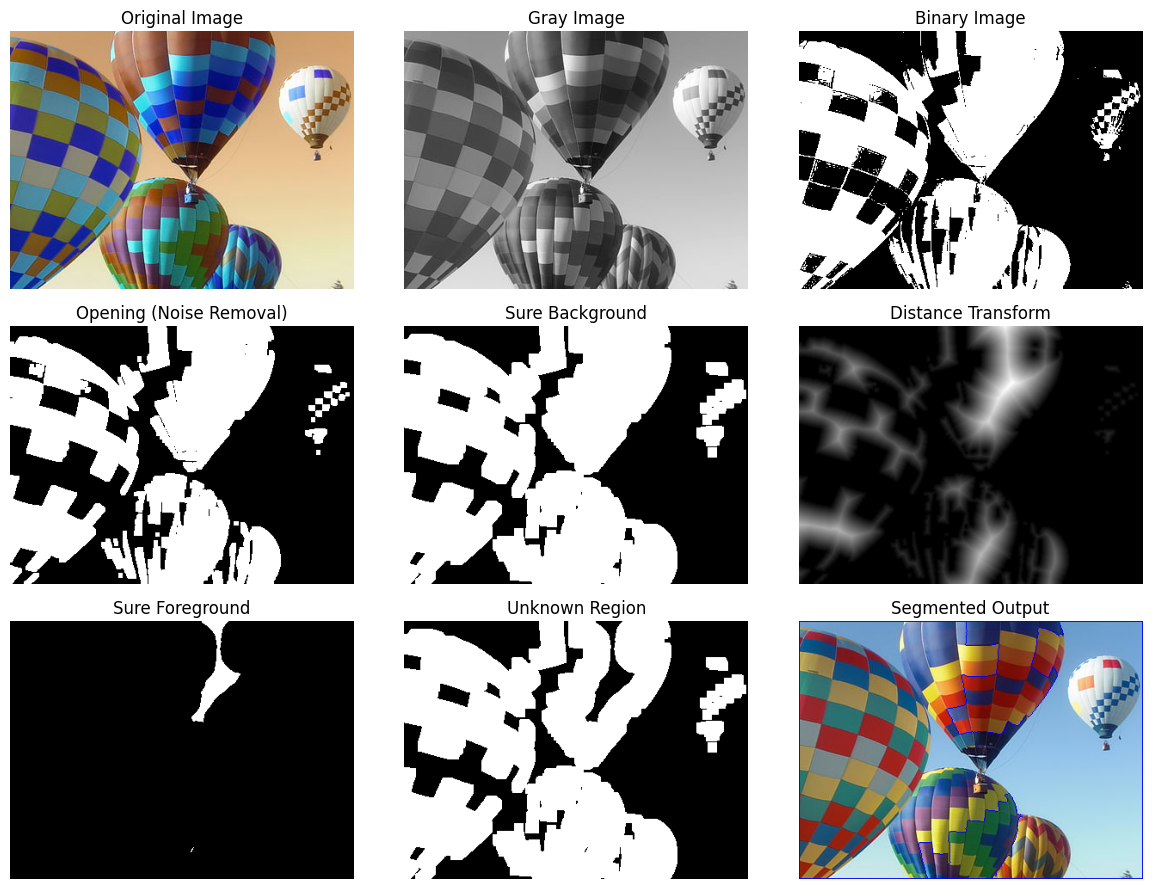

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def watershed_segmentation(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    img_copy = img.copy()
    cv2.watershed(img_copy, markers)
    img_copy[markers == -1] = [255, 0, 0]

    titles = ['Original Image', 'Gray Image', 'Binary Image',
              'Opening (Noise Removal)', 'Sure Background',
              'Distance Transform', 'Sure Foreground',
              'Unknown Region', 'Segmented Output']

    images = [img_rgb, gray, binary, opening, sure_bg,
              dist_transform, sure_fg, unknown, img_copy]

    plt.figure(figsize=(12, 9))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        if len(images[i].shape) == 2:  # Grayscale images
            plt.imshow(images[i], cmap='gray')
        else:  # RGB images
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run the function
image_path = "./Lab 1.jpg"
watershed_segmentation(image_path)


### K-Means Segmentation

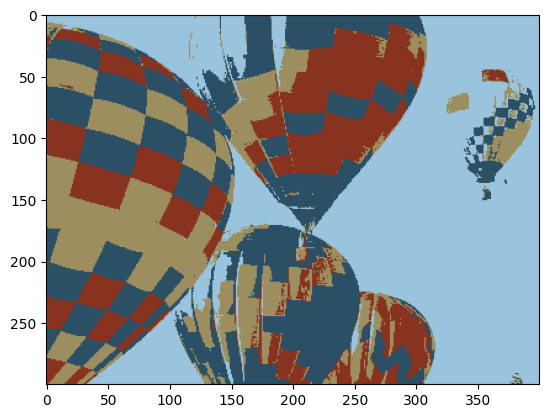

In [2]:
# USING BUILT-IN K MEANS FUNCTION
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

# Read in the image
image = cv2.imread('./Lab 1.jpg')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
pixel_vals = image.reshape((-1,3))

# Convert to float type
pixel_vals = np.float32(pixel_vals)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

k = 4
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]

# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image.shape))

plt.imshow(segmented_image)


### Observations

- Choose Otsu's for simple, fast binary segmentation when you have good contrast and expect a global threshold to work. (Ensure you use a correct implementation that checks all thresholds).
- Choose Watershed when the main challenge is separating objects that touch or overlap, and you can define good markers (often requiring careful pre-processing and parameter tuning).
- Choose K-Means when you want to segment based primarily on color or intensity similarity, need multiple segments, and know roughly how many segments (k) to expect. It's often used for color reduction or identifying dominant color regions.
